# Celltypist Confidence score analyisis

Celltypist is a deep-learning based Cell type prediction model. It takes transcript counts from important genes as input and predicts a cell type as output. Alson gwith the cell type prediction, celltypist provides confidence scores corresponding to the predictions. These can be used to asess the confidence of the mapping as well as to find cell groups where the model struggles.

please use the environment tmp_celltypist (YAML file in environments folder)

Here we take a look at the Xenium data directly

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import spatialdata as sd
import scanpy as sc
import celltypist
from celltypist import models

In [14]:
zarr_path = "/srv/GT/analysis/rdegottardi/data/Xenium_Lung_canc_5k/Xenium.zarr"
sdata = sd.read_zarr(zarr_path)

version mismatch: detected: RasterFormatV02, requested: FormatV04
root_attr: multiscales
root_attr: omero
root_attr: spatialdata_attrs
datasets [{'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0], 'type': 'scale'}], 'path': '0'}, {'coordinateTransformations': [{'scale': [1.0, 2.0, 2.0], 'type': 'scale'}], 'path': '1'}, {'coordinateTransformations': [{'scale': [1.0, 4.0, 4.000147918053399], 'type': 'scale'}], 'path': '2'}, {'coordinateTransformations': [{'scale': [1.0, 8.000856898029134, 8.000887573964498], 'type': 'scale'}], 'path': '3'}, {'coordinateTransformations': [{'scale': [1.0, 16.00171379605827, 16.001775147928996], 'type': 'scale'}], 'path': '4'}]
resolution: 0
 - shape ('c', 'y', 'x') = (4, 37348, 54086)
 - chunks =  ['1', '4096 (+ 484)', '4096 (+ 838)']
 - dtype = uint16
resolution: 1
 - shape ('c', 'y', 'x') = (4, 18674, 27043)
 - chunks =  ['1', '4096 (+ 2290)', '4096 (+ 2467)']
 - dtype = uint16
resolution: 2
 - shape ('c', 'y', 'x') = (4, 9337, 13521)
 - chunks =  

In [15]:

cells_adata_path = "/srv/GT/analysis/rdegottardi/data/Xenium_Lung_canc_5k/cell_feature_matrix.h5"

model_name1 = "Human_Lung_Atlas.pkl"
model_name2 = "Cells_Lung_Airway.pkl"

In [16]:
adata = sdata['table']   #sc.read_10x_h5(cells_adata_path)
adata

AnnData object with n_obs × n_vars = 278328 × 5001
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

The expression matrix (`adata.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [17]:
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)
adata.obs["lib_size"] = lib_size

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [18]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/degottardiraphael/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChall

In [19]:
predictions1 = celltypist.annotate(adata, model = model_name1, majority_voting = True)

🔬 Input data has 278328 cells and 5001 genes
🔗 Matching reference genes in the model
🧬 1750 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!


In [20]:
predictions2 = celltypist.annotate(adata, model = model_name2, majority_voting = True)

🔬 Input data has 278328 cells and 5001 genes
🔗 Matching reference genes in the model
🧬 1820 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!


In [21]:
adata = predictions1.to_adata( prefix= 'M1_')

In [22]:
adata = predictions2.to_adata( prefix= 'M2_')

## Results for the  "Human_Lung_Atlas.pkl" model

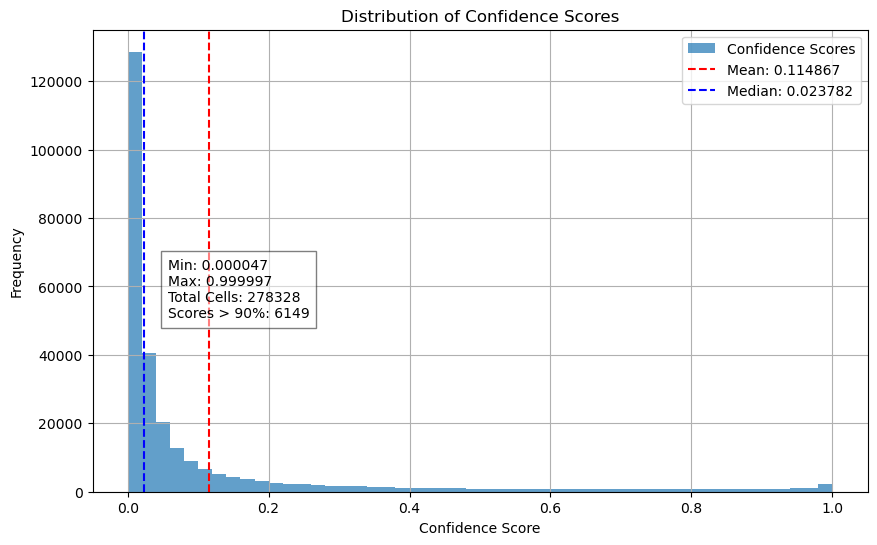

In [23]:
# Calculate mean, median, and total number of cells
mean_conf_score = adata.obs['M1_conf_score'].mean()
median_conf_score = adata.obs['M1_conf_score'].median()
total_cells = adata.obs['M1_conf_score'].shape[0]

# Plot histogram
adata.obs['M1_conf_score'].hist(bins=50, figsize=(10, 6), alpha=0.7, label='Confidence Scores')
plt.axvline(mean_conf_score, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_conf_score:.6f}')
plt.axvline(median_conf_score, color='blue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_conf_score:.6f}')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Display summary metrics
num_scores_above_90 = (adata.obs['M1_conf_score'] > 0.9).sum()
summary_text = (
    f"Min: {adata.obs['M1_conf_score'].min():.6f}\n"
    f"Max: {adata.obs['M1_conf_score'].max():.6f}\n"
    f"Total Cells: {total_cells}\n"
    f"Scores > 90%: {num_scores_above_90}"
)
plt.figtext(0.2, 0.4, summary_text, fontsize=10, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.show()

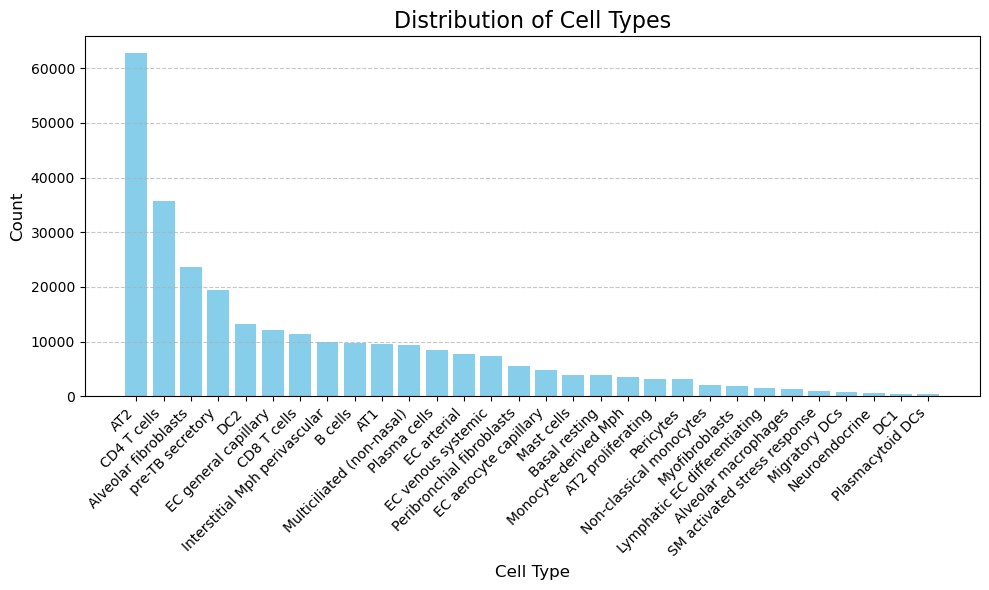

In [24]:
cell_type_counts = adata.obs["M1_majority_voting"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type MV", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type MV"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Results for the  "Cells_Lung_Airway.pkl" model

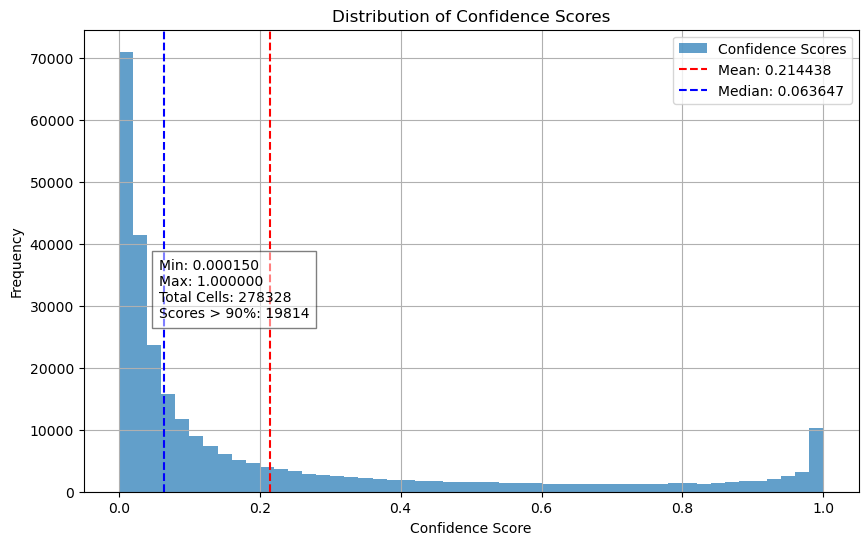

In [25]:
# Calculate mean, median, and total number of cells
mean_conf_score = adata.obs['M2_conf_score'].mean()
median_conf_score = adata.obs['M2_conf_score'].median()
total_cells = adata.obs['M2_conf_score'].shape[0]

# Plot histogram
adata.obs['M2_conf_score'].hist(bins=50, figsize=(10, 6), alpha=0.7, label='Confidence Scores')
plt.axvline(mean_conf_score, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_conf_score:.6f}')
plt.axvline(median_conf_score, color='blue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_conf_score:.6f}')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Display summary metrics
num_scores_above_90 = (adata.obs['M2_conf_score'] > 0.9).sum()
summary_text = (
    f"Min: {adata.obs['M2_conf_score'].min():.6f}\n"
    f"Max: {adata.obs['M2_conf_score'].max():.6f}\n"
    f"Total Cells: {total_cells}\n"
    f"Scores > 90%: {num_scores_above_90}"
)
plt.figtext(0.2, 0.4, summary_text, fontsize=10, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.show()

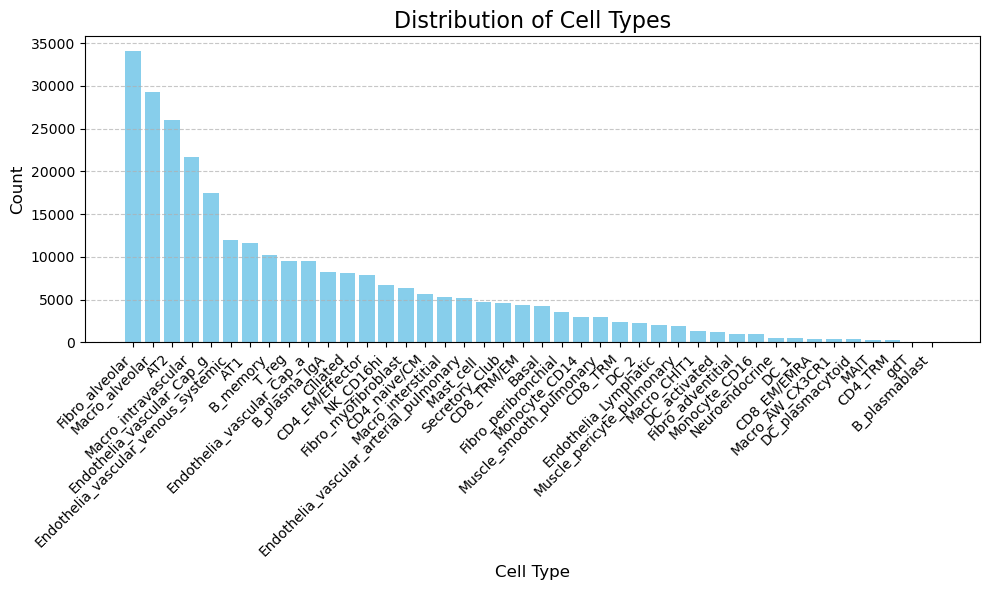

In [26]:
cell_type_counts = adata.obs["M2_majority_voting"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type MV", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type MV"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

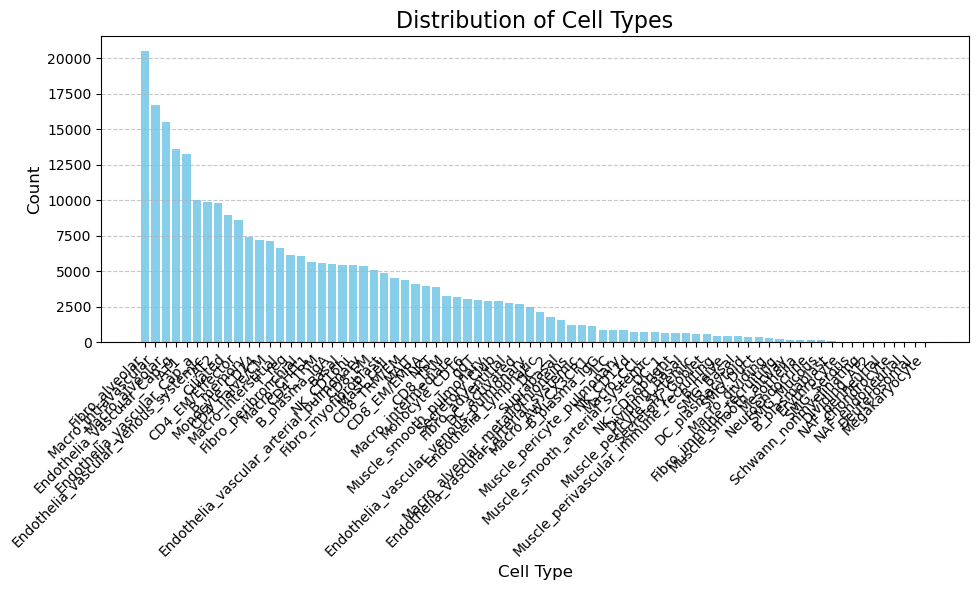

In [27]:
cell_type_counts = adata.obs["M2_predicted_labels"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type pred", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type pred"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Relation
We compare the two predictions using a dotplot and notice that they do not correspond well to each other. We suspect that this is due to bad results at least using the Lung_Atlas_Model.

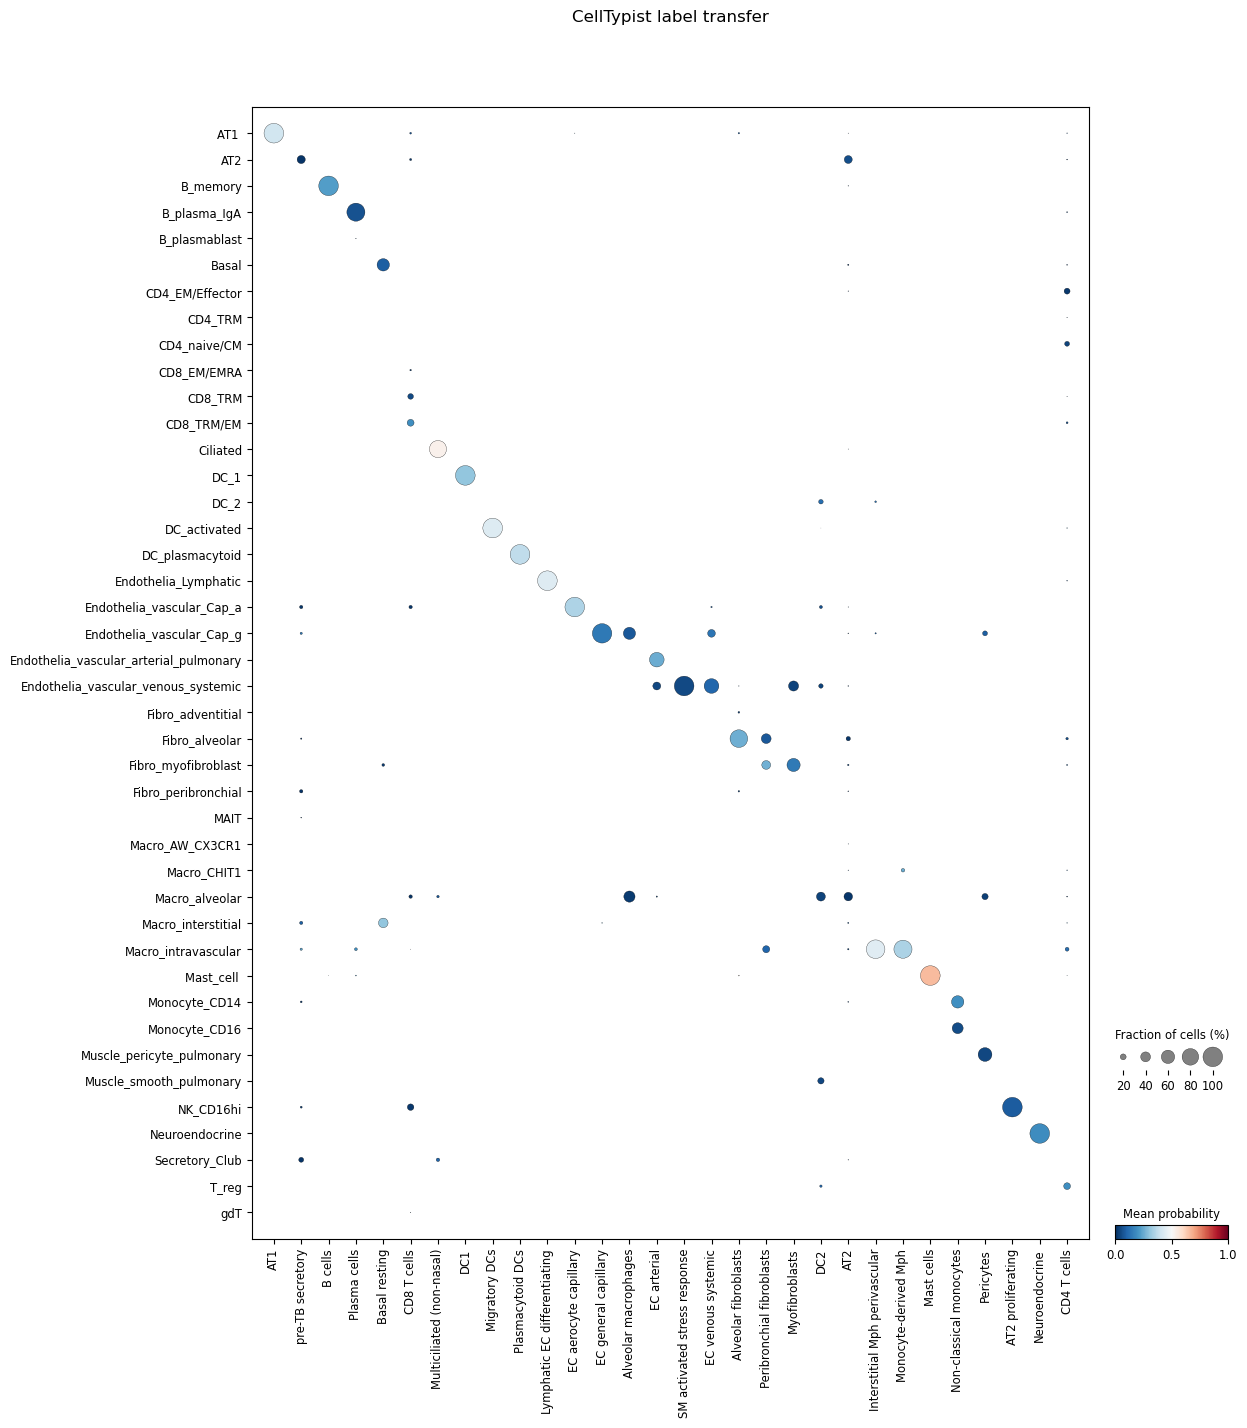

In [30]:
celltypist.dotplot(predictions2, use_as_reference = 'M1_majority_voting', use_as_prediction = 'majority_voting')

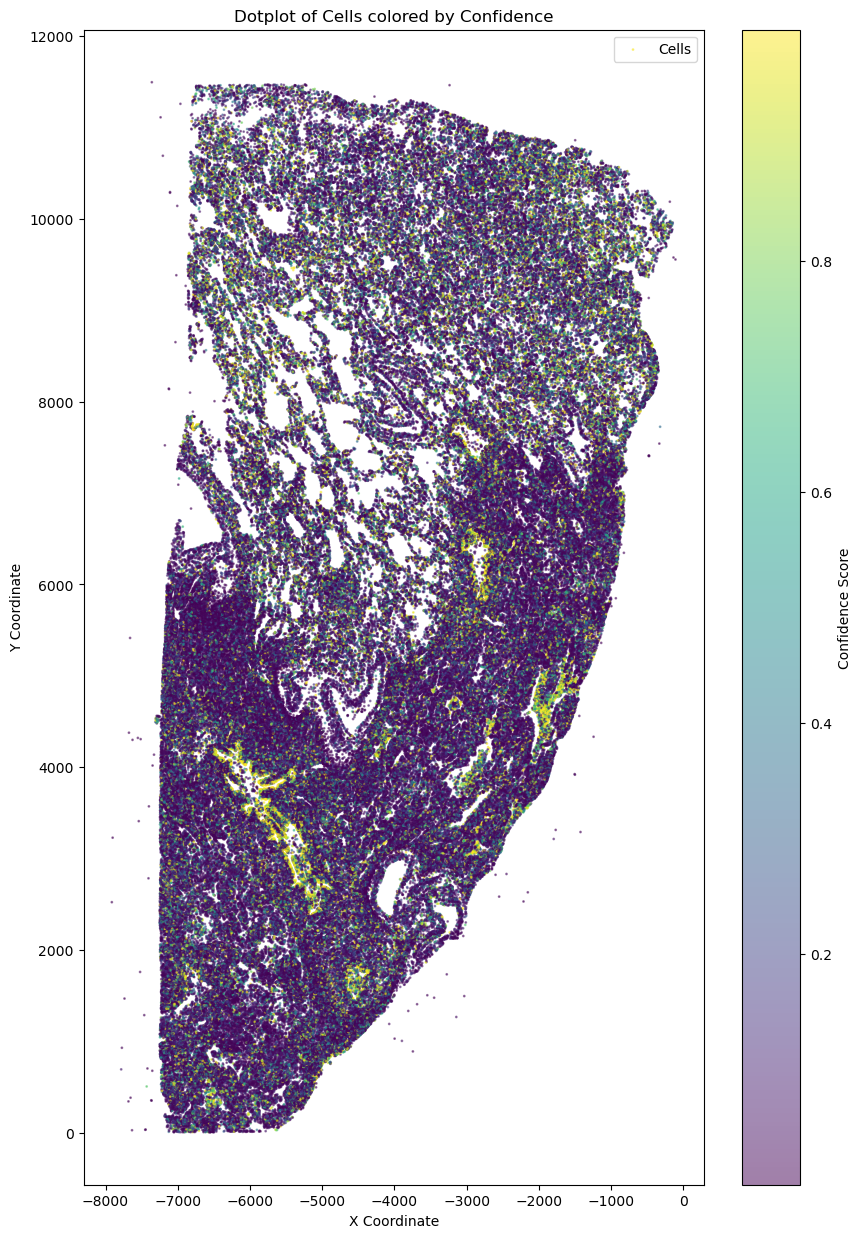

In [36]:

# Create the plot
plt.figure(figsize=(10, 15))
plt.scatter(
    -adata.obsm['spatial'][:,1],
    adata.obsm['spatial'][:,0],
    s=1,
    alpha=0.5,
    c=adata.obs['M2_conf_score'],
    cmap='viridis',
    label='Cells'
)
plt.colorbar(label='Confidence Score')

# Add labels and legend
plt.title('Dotplot of Cells colored by Confidence')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

In [47]:
# Find NaN values in the 'Broad_Cell_Type' column
nan_mask = adata.obs['Broad_Cell_Type'].isna()
# Filter out rows with NaN in 'Broad_Cell_Type'
adata = adata[~nan_mask].copy()

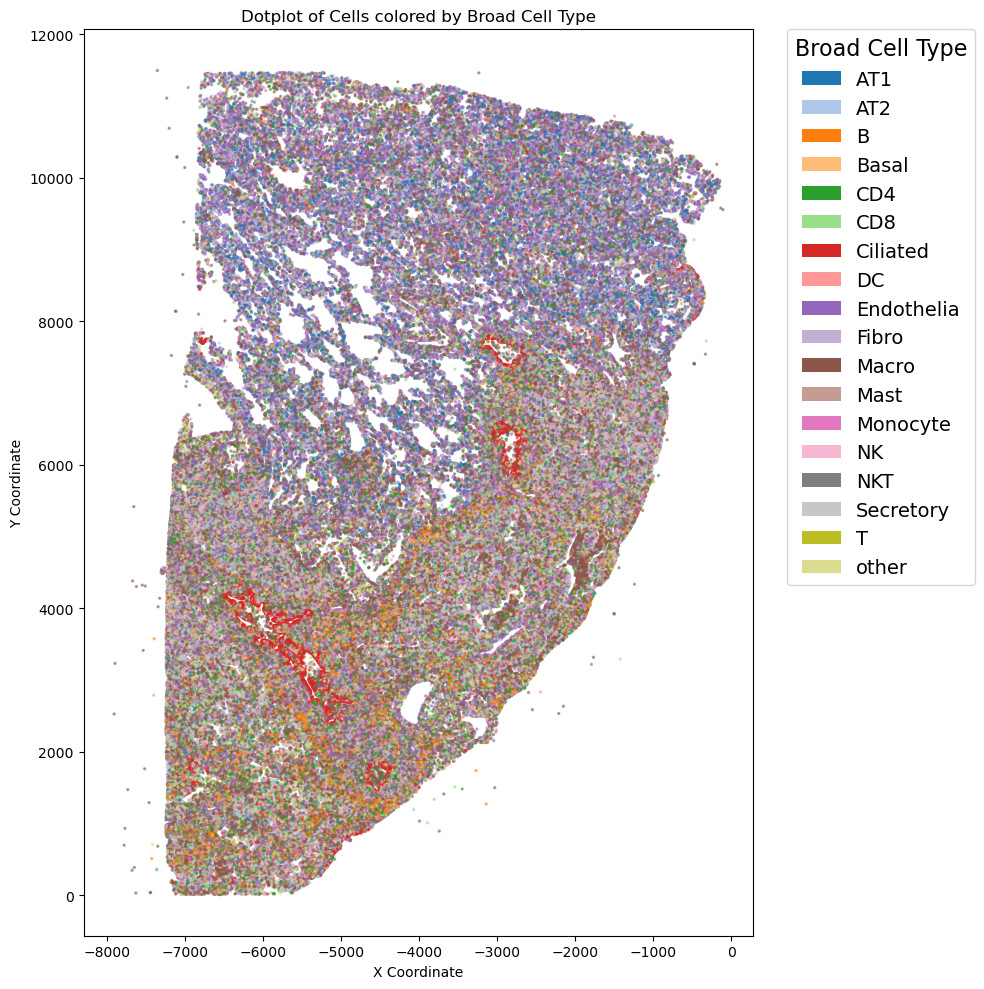

In [48]:
from matplotlib.patches import Patch
import json

# Load the cell type map from the specified JSON file
with open('/home/degottardiraphael/MasterThesis/Benchmarking pipeline/CellTypeAssignment metrics/Celltypist/cell_type_map_VpX.json', 'r') as f:
    cell_type_map = json.load(f)
adata.obs['Broad_Cell_Type'] = adata.obs["M2_predicted_labels"].map(cell_type_map)

colors = plt.cm.tab20.colors  # Use a colormap with enough distinct colors
cell_types = adata.obs['Broad_Cell_Type'].unique()
cell_types = np.sort(cell_types.astype(str))
# Assign a color to each cell type
color_map = {cell_type: colors[i % len(colors)] for i, cell_type in enumerate(cell_types)}
# Plot the spatial scatter as before
plt.figure(figsize=(10, 10))
plt.scatter(
    -adata.obsm['spatial'][:,1],
    adata.obsm['spatial'][:,0],
    s=2,
    alpha=0.5,
    c=[color_map[cell_type] for cell_type in adata.obs['Broad_Cell_Type']],
    label='Cells'
)

plt.title('Dotplot of Cells colored by Broad Cell Type')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Create custom legend
legend_elements = [
    Patch(facecolor=color_map[cell_type], label=cell_type)
    for cell_type in cell_types
]
plt.legend(
    handles=legend_elements,
    title="Broad Cell Type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize=14,
    title_fontsize=16
)

plt.tight_layout()
plt.show()

In [54]:
# Filter adata by spatial coordinates: y > 2200 and x < 6300
spatial = adata.obsm['spatial']
mask = (spatial[:, 0] < 6300) & (spatial[:, 1] > 2200)
adata_filtered = adata[mask].copy()
print(f"Filtered AnnData shape: {adata_filtered.shape}")

Filtered AnnData shape: (162155, 5001)


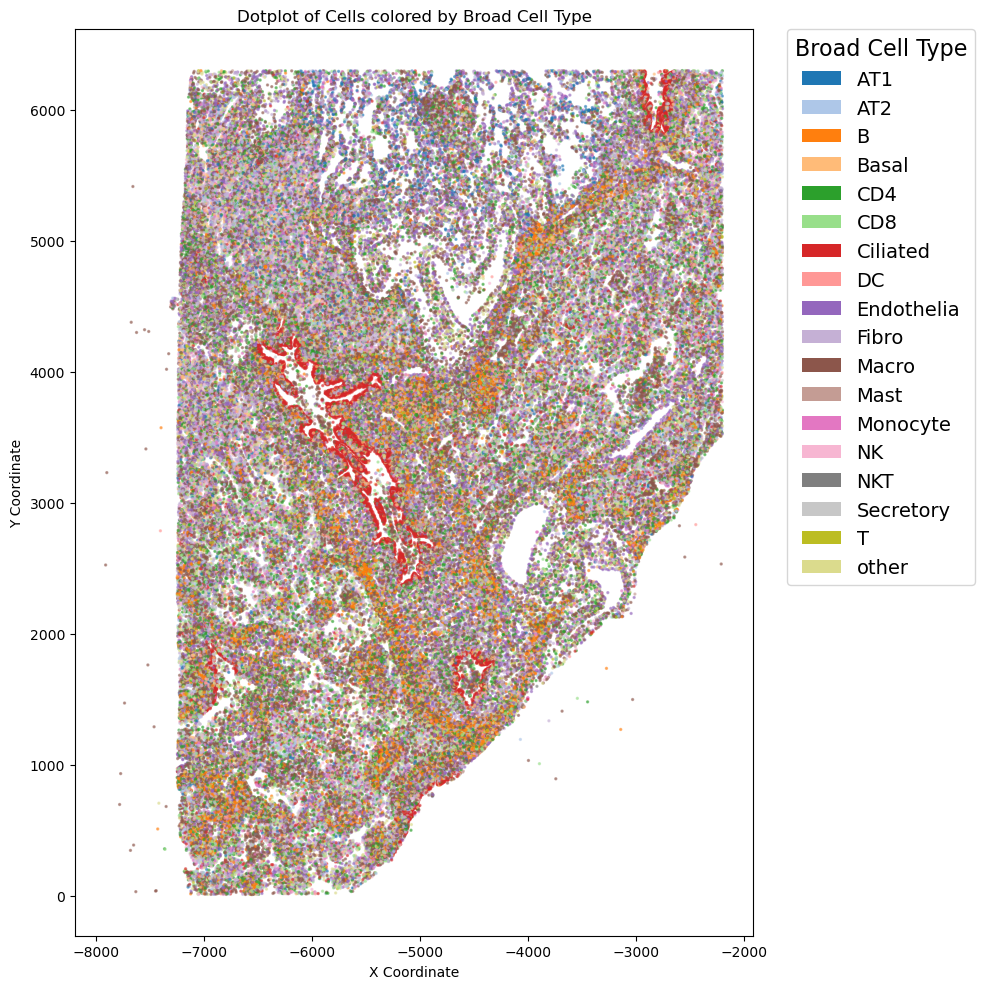

In [55]:

plt.figure(figsize=(10, 10))
plt.scatter(
    -adata_filtered.obsm['spatial'][:,1],
    adata_filtered.obsm['spatial'][:,0],
    s=2,
    alpha=0.5,
    c=[color_map[cell_type] for cell_type in adata_filtered.obs['Broad_Cell_Type']],
    label='Cells'
)

plt.title('Dotplot of Cells colored by Broad Cell Type')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Create custom legend
legend_elements = [
    Patch(facecolor=color_map[cell_type], label=cell_type)
    for cell_type in cell_types
]
plt.legend(
    handles=legend_elements,
    title="Broad Cell Type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize=14,
    title_fontsize=16
)

plt.tight_layout()
plt.show()

In [57]:
csv_path = '/home/degottardiraphael/MasterThesis/Benchmarking pipeline/CellTypeAssignment metrics/Celltypist/Celltypist_confidence_scores.csv'
model_name = 'Xenium'
conf_scores = adata.obs['M2_conf_score']
csv_path = '/home/degottardiraphael/MasterThesis/Benchmarking pipeline/CellTypeAssignment metrics/Celltypist/Celltypist_confidence_scores.csv'
df_csv = pd.read_csv(csv_path)
# Ensure the lengths match before assignment
if len(df_csv) == len(conf_scores):
    df_csv[model_name] = conf_scores.values
else:
    print(f"Length mismatch: df_csv has {len(df_csv)} rows, conf_scores has {len(conf_scores)} rows.")
    # Fill the remaining rows with NaN for the new column
    df_csv[model_name] = pd.Series(conf_scores.values).reindex(df_csv.index)
print(df_csv.head())

Length mismatch: df_csv has 1300000 rows, conf_scores has 278322 rows.
     Bin8x8  Bin2Cell     Enact      Xseg    Tonsil     ScRef    Xenium
0  0.173920  0.415195  0.062796  0.043314  0.065704  0.219440  0.993406
1  0.111783  0.308685  0.028867  0.896519  0.417705  0.999260  0.035353
2  0.653658  0.219721  0.031286  0.397644  0.263028  0.970444  0.081120
3  0.790891  0.318133  0.050490  0.229899  0.068869  0.946018  0.018678
4  0.189795  0.124476  0.199702  0.662286  0.039881  0.973019  0.040255


In [ ]:
#df_csv.to_csv(csv_path, index=False)

In [ ]:

# Load the existing CSV
csv_file = './Celltypist_predicted_cell_types_counts.csv'
existing = pd.read_csv(csv_file)

cell_type_counts = cell_type_counts.rename(columns={'Count': model_name})
# Merge on 'Cell Type pred', updating counts for matching cell types
merged = existing.merge(cell_type_counts, on='Cell Type pred', how='outer')

    
# Save back to CSV
merged #.to_csv(csv_file, index=False)